# plotting functions of supplmentary figure 3 in the manuscript
This figure shows the 3D classification of the covid spike monomer steered MD simulation and c3c3b steered MD simulation.

his figure shows the following:

- Panel showing distribution of particles in each 3D class over the frames of the steered MD simulation


In [1]:
# imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mrcfile

# roodmus
from roodmus.analysis.utils import load_data

In [2]:
### data loading (6xm5 steered MD)
project_dir = "/home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2"
config_dir = os.path.join(project_dir, "mrc")
figures_dir = os.path.join(project_dir, "figures")
meta_files = [
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_0.cs"),
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_1.cs"),
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_2.cs"),
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_3.cs"),
]

jobtypes = {
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_0.cs"): "ab initio class 0",
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_1.cs"): "ab initio class 1",
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_2.cs"): "ab initio class 2",
    os.path.join(project_dir, "cryoSPARC", "J519_passthrough_particles_class_3.cs"): "ab initio class 3",
}

particle_diameter = 100 # approximate particle diameter in Angstroms
ugraph_shape = (4000, 4000) # shape of the micrograph in pixels. Only needs to be given if the metadata file is a .star file
verbose = True # prints out progress statements
ignore_missing_files = True # if .mrc files are missing, the analysis will still be performed
enable_tqdm = True # enables tqdm progress bars

for i, meta_file in enumerate(meta_files):
    if i == 0:
        analysis = load_data(meta_file, config_dir, particle_diameter, ugraph_shape=ugraph_shape, verbose=verbose, enable_tqdm=enable_tqdm, ignore_missing_files=ignore_missing_files) # creates the class
    else:
        analysis.add_data(meta_file, config_dir, verbose=verbose) # updates the class with the next metadata file
df_picked = pd.DataFrame(analysis.results_picking)
df_truth = pd.DataFrame(analysis.results_truth)
df_precision, df_picked = analysis.compute_precision(df_picked, df_truth, verbose=verbose)
print(f"mean precision: {df_precision['precision'].mean()}")
print(f"mean recall: {df_precision['recall'].mean()}")

df_picked["jobtype"] = df_picked["metadata_filename"].map(jobtypes)
print(f"total number of particles loaded: {len(df_picked)}")
print(f"number of particles in class 0: {len(df_picked[df_picked['jobtype'] == 'ab initio class 0'])}")
df_picked.head()

loading metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_0.cs...
loaded metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_0.cs. determined file type: cs


Dictionaries now contain 70581 reconstructed particles
added 70581 particles from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_0.cs


loading truth data: 100%|██████████| 800/800 [05:28<00:00,  2.43it/s, micrograph=000799.mrc]


Loaded ground-truth particle positions from config files
Dictionaries now contain 70581 particles and 200000 true particles
Added 200000 particles from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/mrc
loading metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_1.cs...
loaded metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_1.cs. determined file type: cs
checking if ugraphs exist...


Dictionaries now contain 106859 reconstructed particles
added 36278 particles from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_1.cs
loading metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_2.cs...
loaded metadata from /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryoSPARC/J519_passthrough_particles_class_2.cs. deter

computing precision: 100%|██████████| 3200/3200 [01:03<00:00, 50.01it/s, precision=0.63, recall=0.182, multiplicity=0.188]  


time taken to compute precision: 64.57318997383118
mean precision: 0.8009825495092722
mean recall: 0.2117609932207824


number of TP particles : 168556


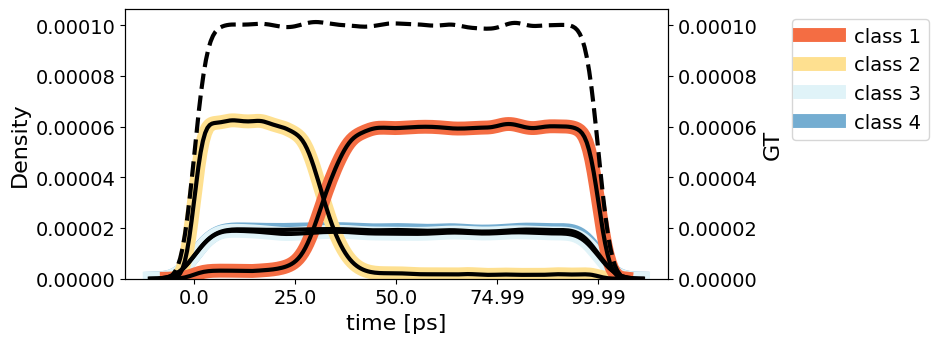

In [8]:
# add a column to the df_picked data frame that indicates if the particles originates from the open or closed state of the spike protein
df_truth["pdb_index"] = df_truth["pdb_filename"].apply(lambda x: int(x.strip(".pdb").split("_")[-1]))
# df_picked["jobtype"] = df_picked["metadata_filename"].apply(lambda x: jobtypes[x])
df_picked_grouped = df_picked.groupby("TP").get_group(True)
print(f"number of TP particles : {len(df_picked_grouped)}")
num_classes = len(df_picked_grouped["jobtype"].unique())

dt = 0.01 # ps timeinterval between frames

fig, ax = plt.subplots(figsize=(7, 3.5))
# make kde plot out of the data
kde_picked = sns.kdeplot(
    data=df_picked_grouped,
    x="closest_pdb_index",
    ax=ax,
    hue="jobtype",
    fill=False,
    label="jobtype",
    linewidth=10,
    alpha=1,
    palette="RdYlBu",
    legend=True,
)
# add an extra black line over the second class
kde_extra = sns.kdeplot(
    data=df_picked_grouped,
    x="closest_pdb_index",
    ax=ax,
    hue="jobtype",
    palette={f"{r}": "black" for r in df_picked_grouped["jobtype"].unique()},
    label="picked_particles",
    linewidth=3,
    alpha=1,
    fill=False,
    legend=False,
)
# add kdeplot of the True particles
ax_truth = ax.twinx()
kde_truth = sns.kdeplot(
    data=df_truth,
    x="pdb_index",
    ax=ax_truth,
    color="black",
    linestyle="--",
    label="GT",
    linewidth=3,
    fill=False,
    alpha=1,
    legend=True,
)

# get the legend handles from kde_picked
handles, labels = ax.get_legend_handles_labels()
h = [handles[r] for r in range(len(handles)) if labels[r] == "jobtype"]
h = h[::-1]
h.extend([handles[r] for r in range(len(handles)) if labels[r] == "GT"])
l = [f"class {r+1}" for r in range(num_classes)] + ["GT"]
# add the legend
ax.legend(
    handles=h,
    labels=l,
    loc='upper right',
    bbox_to_anchor=(1.50, 1.0),
    ncol=1,
    fontsize=14,
    frameon=True,
)
ax_truth.set_ylabel("GT", fontsize=16)
if num_classes == 10:
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1]*1.1)
else:
    ylim = ax_truth.get_ylim()
    ax.set_ylim(ylim[0], ylim[1])

# change the xticks to the time in us
ax.set_xticks(np.linspace(0, df_truth["pdb_index"].max(), 5))
ax.set_xticklabels(np.linspace(0, df_truth["pdb_index"].max()*dt, 5).round(2), fontsize=14)
ax.set_xlabel("time [ps]", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax_truth.tick_params(axis='both', which='major', labelsize=14)

# save the figure
fig.savefig(os.path.join(project_dir, "figures", f"frame_distribution.pdf"), bbox_inches="tight")


saved figure to /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/figures/precision_per_class.pdf


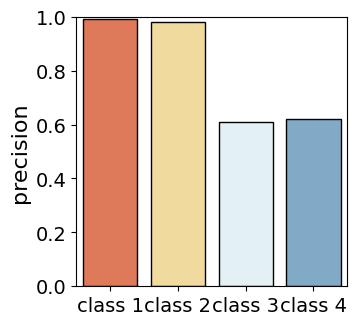

In [13]:
# plot the preicison per 3D class
df_precision["jobtype"] = df_precision["metadata_filename"].apply(lambda x: jobtypes[x].replace("ab initio", ""))
# change the numbering in the classes from 0-n to 1-n+1
df_precision["jobtype"] = df_precision["jobtype"].apply(lambda x: f"class {int(x.split()[-1])+1}")
num_classes = len(df_precision["jobtype"].unique())
colors = sns.color_palette("RdYlBu", n_colors=num_classes)

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.barplot(
    data=df_precision,
    x="jobtype",
    y="precision",
    hue="jobtype",
    palette=colors,
    edgecolor='black',
    ax=ax,
    dodge=0,
    linewidth=1,
    errorbar=None,
)
ax.set_ylim((0, 1))
ax.set_ylabel("precision", fontsize=16)
ax.set_xlabel("")
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend().remove()

fig.savefig(os.path.join(project_dir, "figures", f"precision_per_class.pdf"), bbox_inches="tight")
print(f"saved figure to {os.path.join(project_dir, 'figures', 'precision_per_class.pdf')}")


saved figure to /home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/figures/particle_fraction_per_class.pdf


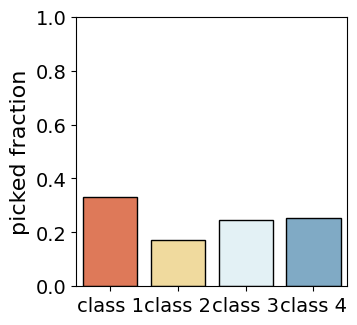

In [16]:
results = {
    "class": [],
    "picked_fraction": [],
}
for jobtype in df_picked["jobtype"].unique():
    results["class"].append(jobtype.replace("ab initio", ""))
    results["picked_fraction"].append(len(df_picked[df_picked["jobtype"] == jobtype]) / len(df_picked))
df_results = pd.DataFrame(results)
df_results["class"] = df_results["class"].apply(lambda x: f"class {int(x.split()[-1])+1}")

fig, ax = plt.subplots(figsize=(3.5, 3.5))
sns.barplot(
    data=df_results,
    x="class",
    y="picked_fraction",
    hue="class",
    palette=colors,
    edgecolor='black',
    ax=ax,
    dodge=0,
    linewidth=1,
)
ax.set_ylim((0, 1))
ax.set_ylabel("picked fraction", fontsize=16)
ax.set_xlabel("")
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend().remove()

fig.savefig(os.path.join(project_dir, "figures", f"particle_fraction_per_class.pdf"), bbox_inches="tight")
print(f"saved figure to {os.path.join(project_dir, 'figures', 'particle_fraction_per_class.pdf')}")


In [52]:
# flipping volume
volumes_to_flip = [
    # "/home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryosparc_P51_J519/cryosparc_P51_J519_class_00_final_volume.mrc",
    "/home/mjoosten1/projects/roodmus/data/6xm5_steered_Roodmus_2/cryosparc_P51_J520/cryosparc_P51_J520_003_volume_map_sharp.mrc",
]

for volume_to_flip in volumes_to_flip:
    with mrcfile.open(volume_to_flip, mode='r', permissive=True) as mrc:
        volume = mrc.data
        vsize = mrc.voxel_size
    with mrcfile.new(volume_to_flip.replace(".mrc", "_flipped.mrc"), overwrite=True) as mrc:
        mrc.set_data(np.flip(volume, axis=0))
        mrc.voxel_size = vsize
        


In [51]:
# print the colors for the 4 classes as hex values
colors = sns.color_palette("RdYlBu", n_colors=num_classes)
for color in colors:
    # convert the rgb values to hex
    color_hex = '#%02x%02x%02x' % tuple([int(r*255) for r in color])
    print(color_hex)
    



#f46d43
#fee090
#e0f3f7
#74add1


In [55]:
# print the total number of TP and FP particles in the dataset
print(f"total number of TP particles: {len(df_picked_grouped)}")
print(f"total number of FP particles: {len(df_picked[df_picked['TP'] == False])}")
print(f"total number of particles: {len(df_picked)}")

# print the precision and recall per class
df_precision = df_precision.groupby("jobtype").agg({"precision": "mean", "recall": "mean"})
df_precision.head()

total number of TP particles: 168556
total number of FP particles: 44930
total number of particles: 213486


,precision,recall
jobtype,,
class 0,0.993052,0.354775
class 1,0.979528,0.178860
class 2,0.609855,0.152223
class 3,0.621496,0.161186
